In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


class OptionPricing:
    
    '''
    A class that computes the option price of European options using Black-Sholes, European and American options 
    using Monte-Carlo simulation, Greeks Delta and Vega.
    
    parameters:
    -----------
    S_0: Value of the underlying asset
    K: Strike price
    sigma: Volatility of the underlying asset
    r: risk-free rate of interest
    T: Time to maturity (in years)
    option_type: 
            values: call / put
    option_style:
            values: European / American
            
    Methods:
    --------
    compute_black_scholes():
            Computes the price of European option using Black-Scholes closed form solution.
    
    compute_monte_carlo(iterations, uao, uai):
            Computes the price of European / American option by simulating the asset price over daily time period
            with specified number of iterations.
            
            parameters:
            -----------
            iterations: Number of Monte-Carlo simulations
            uao (default: np.inf): Barrier of a uao option
            uai (default: 0): Barrier of a uai option
            
    compute_delta_bs():
            Uses Black-Scholes closed form solution to compute the Greek Delta of the option.
            
    compute_vega_bs():
            Uses Black-Scholes closed form solution to compute the Greek Vega of the option.
            
    compute_delta_mc():
            Uses the Monte-Carlo simulation prices and the payoff to compute the Greek Delta of the option.
    '''
    
    def __init__(self, S, K, sigma, r, T, option_type, option_style):
        self.S = S
        self.K = K
        self.sigma = sigma
        self.r = r
        self.T = T
        self.option_type = option_type
        self.option_style = option_style
        
    def __compute_pde(self):
        self.d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) \
                / (self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - (self.sigma * np.sqrt(self.T))
        
        return self.d1, self.d2
        
    def compute_black_scholes(self):
        d1, d2 = self.__compute_pde()
        
        if self.option_type == "call":
            price = (self.S * norm.cdf(d1)) - (self.K * np.exp(-self.r * self.T) * norm.cdf(d2)) 

        elif self.option_type == "put":
            price = (self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)) - (self.S * norm.cdf(-d1))

            if self.option_style == "American":
                return None

        return np.round(price, 2)
    
    def compute_monte_carlo(self, iterations, uao=np.inf, uai=0):
        n = 365
        steps = int(self.T * n)
      
        z = np.random.standard_normal([iterations, steps])
        
        self.S_t = np.zeros([iterations, steps])
                
        self.S_t[0:, 0] = self.S
        
        for j in range(1, steps):
            for i in range(iterations):
                self.S_t[i, j] = self.S_t[i, j-1] * \
                    np.exp(((self.r - self.sigma**2/2) * self.T / steps) + self.sigma * np.sqrt(self.T / steps) * z[i, j])
        
        barrier_uao = self.S_t >= uao
        barrier_uai = ~(self.S_t >= uai)
                
        if self.option_type == "call":
            self.Op = np.maximum(self.S_t - self.K, 0)
            
        elif self.option_type == "put":
            self.Op = np.maximum(self.K - self.S_t, 0)
        
        for i in range(iterations):
            if barrier_uao[i].any():
                self.Op[i, np.argmax(barrier_uao[i]):] = 0
                
            if barrier_uai[i].all():
                 self.Op[i, :] = 0
                
        pricing = np.exp(-self.r * self.T) * self.Op[:, -1]
        
        
        if self.option_type == "put" and self.option_style == "American": 
            pricing = []
            for i in range(iterations):              
                for j in range(steps):
                    if self.Op[i, j] >= self.Op[i, -1] * np.exp(-self.r * self.T):
                        pricing.append(self.Op[i, j] * np.exp(-self.r * j / steps))
                        break
    
        price = np.mean(pricing)
        
        return np.round(price, 2)
        
    def compute_delta_bs(self):
        
        d1 = self.__compute_pde()[0]
        
        if self.option_type == "call":           
            delta = norm.cdf(d1)   
        elif self.option_type == "put":
            delta = norm.cdf(d1) - 1
            
        return np.round(delta, 3)
    
    def compute_vega_bs(self):
        
        d1 = self.__compute_pde()[0]
    
        vega = self.S * norm.pdf(d1) * np.sqrt(self.T)
            
        return np.round(vega, 3)  
    
    def compute_delta_mc(self):
        
        return np.round(np.mean((self.Op[:, -1] - self.Op[:, 0]) / (self.S_t[:, -1] - self.S_t[:, 0])),3)

In [3]:
OptionPricing(80, 80, 0.35, 0.055, 3/12, "put", "European").compute_black_scholes()

5.01

<div style="page-break-after: always;"></div>

# <center>Step 1</center>

### 1. Pricing of European call and put option using Black-Scholes closed form solution and computing the Greeks

$
\hspace{1cm}S_0 = 100 \\
\hspace{1cm}r = 5\% \\
\hspace{1cm}\sigma = 20\% \\
\hspace{1cm}T = 3 months
$

#### Price of an ATM European call and put using Black-Scholes closed form solution.

As the number of steps in the binomial tree approaches infinity, the model approaches the continuous-time Black-Scholes model. The Black-Scholes model provides a closed-form solution for the price of a European option, while the binomial model requires numerical methods to calculate the option price.

The Black-Scholes formula for call and put are:

$
\begin{align*}
\hspace{1cm}\text{Call option:} \\
\hspace{2cm} C &= S_0 \mathcal{N}(d_1) - K e^{-rT} \mathcal{N}(d_2) \\[2em]
\hspace{1cm}\text{Put option:} \\
\hspace{2cm} P &= K e^{-rT} \mathcal{N}(-d_2) - S_0 \mathcal{N}(-d_1) \\[2em]
\hspace{1cm}\text{where:} \\
\hspace{2cm} S_0 &= \text{current price of the underlying asset} \\[0.5em]
\hspace{2cm} K &= \text{strike price of the option} \\[0.5em]
\hspace{2cm} T &= \text{time to expiration of the option} \\[0.5em]
\hspace{2cm} r &= \text{risk-free interest rate} \\[0.5em]
\hspace{2cm} \sigma &= \text{volatility of the underlying asset's returns} \\[0.5em]
\hspace{2cm} d_1 &= \frac{\ln(S_0/K) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} \\[0.5em]
\hspace{2cm} d_2 &= d_1 - \sigma\sqrt{T} \\[0.5em]
\hspace{2cm} \mathcal{N}(x) &= \text{cumulative distribution function of the standard normal distribution.}
\end{align*}
$

##### Price of European call option

In [2]:
S_0 = 100
K = 100
sigma = 0.2
r = 0.05
T = 3/12


call_option = OptionPricing(S_0, K, sigma, r, T, option_type="call", option_style="European")
call_price_bs = call_option.compute_black_scholes()

print(f"Price of an ATM European call using Black-Scholes: {call_price_bs}")

Price of an ATM European call using Black-Scholes: 4.61


##### Price of European put option

In [3]:
S_0 = 100
K = 100
sigma = 0.2
r = 0.05
T = 3/12


put_option = OptionPricing(S_0, K, sigma, r, T, option_type="put", option_style="European")
put_price_bs = put_option.compute_black_scholes()

print(f"Price of an ATM European put using Black-Scholes: {put_price_bs}")

Price of an ATM European put using Black-Scholes: 3.37


| Method | Call Option | Put Option |
| :---: | :---: | :---: |
| Black-Scholes | 4.61 | 3.37 |

#### Greek Delta for the European call and European put at time 0


Delta of an option represents the change in option's price for a small change in the underlying asset price. The Delta from call option is positive and negative for put options.

$
\hspace{1cm}\Delta(\text{call}) = \mathcal{N}(d_1) \\
\hspace{1cm}\Delta(\text{put}) = \mathcal{N}(d_1) - 1
$



<div style="page-break-after: always;"></div>

##### Delta of call option

In [4]:
print(f"Delta of European call at time 0: {call_option.compute_delta_bs()}")

Delta of European call at time 0: 0.569


##### Delta of put option

In [5]:
print(f"Delta of European call at time 0: {put_option.compute_delta_bs()}")

Delta of European call at time 0: -0.431


|  | Call Option | Put Option |
| --- | --- | --- |
| Delta of European | 0.569 | -0.431 |

#### Greek Vega for the European option

Vega is the sensitivity of the option price to changes in volatility. In general, higher Vega values indicate that an option is more sensitive to changes in volatility.

$
\hspace{1cm}\text{Vega} = \large{\frac{\partial C}{\partial \sigma}} = \large{\frac{\partial P}{\partial \sigma}} = \small{S_0 \sqrt{T} \, \mathcal{N}(d_1)}
$


In [6]:
print(f"Vega of the European option: {call_option.compute_vega_bs()}")

Vega of the European option: 19.644


### 2. Pricing of European call and put option with Monte-Carlo methods under GBM equation and computing the Greeks

#### Price of an ATM European call and put using Monte-Carlo methods

The GBM has the following stochastic differential equation (SDE):

$
\hspace{1cm}dS_t = \mu S_tdt + \sigma S_tdW_t
$

$S_t$ can be solved as,

$
\begin{align*}
\hspace{1cm}S_t &= S_{t-1} \cdot e^{\left(\frac{r-\sigma^2/2}{n}+\sigma \sqrt{\frac{1}{n}} \cdot z\right)} \\[0.5em]
\hspace{1cm}\text{where,} \\
\hspace{2cm}S_{t-1} &= \text{Price at previous step} \\
\hspace{2cm}r &= \text{Risk free rate of interest} \\
\hspace{2cm}\sigma &= \text{Volatility of the returns of underlying asset} \\
\hspace{2cm}n &= \text{Number of time-steps} \\
\hspace{2cm}z &= \mathcal{N}(0,1)
\end{align*}
$

With very large number of time steps, the Monte-Carlo method converges to the same price as the Black-Scholes closed-form solution.

Assuming the interest rate remains constant, the option will be valued as follows:

* Simulate large number of sample paths with daily time steps.
* Calculate the payoff from the options.
* Calculate the mean of the payoffs at expiry to compute the expected payoff.
* Discount the payoff to time $t=0$.

##### Price of European call option

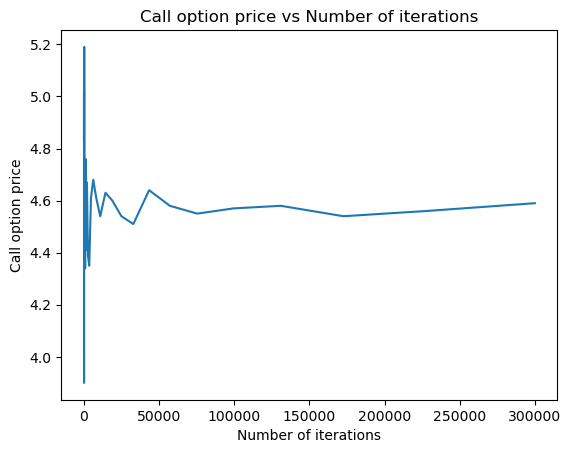

In [7]:
np.random.seed(42)

S_0 = 100
K = 100
sigma = 0.2
r = 0.05
T = 3/12

call_option = OptionPricing(S_0, K, sigma, r, T, option_type="call", option_style="European")

call_prices = dict()

for iteration in np.geomspace(100, 300_000, 30, dtype=int):
    call_prices[iteration] = call_option.compute_monte_carlo(iteration)

plt.plot(call_prices.keys(), call_prices.values())
plt.title("Call option price vs Number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel("Call option price");

The price of the call option converges at around 75 000 iterations. So, we will use 75 000 iterations to price the option.

In [8]:
np.random.seed(42)

S_0 = 100
K = 100
sigma = 0.2
r = 0.05
T = 3/12

call_option = OptionPricing(S_0, K, sigma, r, T, option_type="call", option_style="European")
call_price_mc = call_option.compute_monte_carlo(75_000)

print(f"Price of an ATM European call using Monte-Carlo simulation: {call_price_mc}")

Price of an ATM European call using Monte-Carlo simulation: 4.58


##### Price of European put option

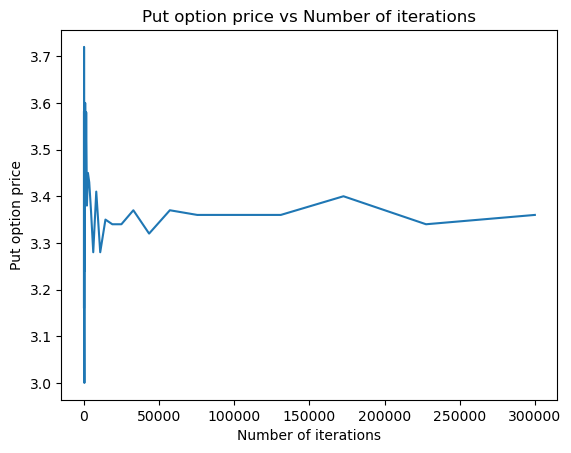

In [9]:
np.random.seed(42)

S_0 = 100
K = 100
sigma = 0.2
r = 0.05
T = 3/12

put_option = OptionPricing(S_0, K, sigma, r, T, option_type="put", option_style="European")

put_prices = dict()

for iteration in np.geomspace(100, 300_000, 30, dtype=int):
    put_prices[iteration] = put_option.compute_monte_carlo(iteration)

plt.plot(put_prices.keys(), put_prices.values())
plt.title("Put option price vs Number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel("Put option price");

<div style="page-break-after: always;"></div>

Again, the price of the put option converges at around 75 000 iterations.

In [10]:
np.random.seed(42)

put_price_mc = put_option.compute_monte_carlo(75_000)

print(f"Price of an ATM European put using Monte-Carlo simulation: {put_price_mc}")

Price of an ATM European put using Monte-Carlo simulation: 3.36


| Method | Call Option | Put Option |
| :---: | :---: | :---: |
| Monte-Carlo | 4.58 | 3.36 |

#### Compute the Greek Delta for the European call and European put at time 0

Delta of the option is computed as the ratio of change in option price to the change in value of underlying asset.

##### Delta of call option

In [11]:
print(f"Delta of European call at time 0: {call_option.compute_delta_mc()}")

Delta of European call at time 0: 0.53


##### Delta of put option

In [12]:
print(f"Delta of European put at time 0: {put_option.compute_delta_mc()}")

Delta of European put at time 0: -0.47


|  | Call Option | Put Option |
| :---: | :---: | :---: |
| Delta of European | 0.53 | -0.47 |

#### Greek Vega for the European option

Vega is the sensitivity of option price to change in volatility. We shall price both call and put options with volatilities 0.20 and 0.25.

##### Call option

In [13]:
np.random.seed(42)

volatilities = [0.2, 0.25]

call_prices = {
    vol: OptionPricing(S_0, K, vol, r, T, "call", "European").compute_monte_carlo(75_000) for vol in volatilities
}

print(f"Price of call option with increasing volatility: \n\t{call_prices}")

Price of call option with increasing volatility: 
	{0.2: 4.58, 0.25: 5.53}


##### Put option

In [14]:
np.random.seed(42)

volatilities = [0.2, 0.25]

put_prices = {
    vol: OptionPricing(S_0, K, vol, r, T, "put", "European").compute_monte_carlo(75_000) for vol in volatilities
}

print(f"Price of put option with increasing volatility: \n\t{put_prices}")

Price of put option with increasing volatility: 
	{0.2: 3.36, 0.25: 4.33}


| Volatility | Call Option | Put Option |
| :---: | :---: | :---: |
| 0.20 | 4.58 | 3.36 |
| 0.25 | 5.53 | 4.33 |

An approximation to vega can be computed as follows:

$
\begin{align*}
\small{\hspace{0.5cm}Vega} &= {\frac{\text{Change in price of option}}{\text{Change in volatility}}} \\[0.5em]
&= \small{\frac{5.53 - 4.58}{0.25 - 0.20}} \\[0.25em]
&= \small{19.00}
\end{align*}
$

<div style="page-break-after: always;"></div>

### Summary

#####  Price of European option 

| Method | Call Option | Put Option |
| :---: | :---: | :---: |
| Binomial tree (GWP1) | 4.60 | 3.35 |
| Trinomial tree (GWP1) | 4.61 | 3.36 |
| Black-Scholes | 4.61 | 3.37 |
| Monte-Carlo| 4.58 | 3.36 |

<br></br>

##### Greeks


| | Call Option | Put Option |
| :---: | :---: | :---: |
| Delta (BS) | 0.569 | -0.431 |
| Delta (MC) | 0.530 | -0.470 |
| Vega (BS) <td colspan=2 style="text-align:center">19.644</td>|
| Vega (MC) <td colspan=2 style="text-align:center">19.000</td>|

### 3. Checking that Put-Call parity is satisfied under both methods (BS and MC).

##### Black Scholes

In [15]:
lhs = np.round(put_price_bs + S_0, 2)
rhs = np.round(call_price_bs + K * np.exp(-r * T), 2)

print(f"LHS: {lhs}")
print(f"RHS: {rhs}")

LHS: 103.37
RHS: 103.37


##### Monte-Carlo

In [16]:
lhs = np.round(put_price_mc + S_0, 2)
rhs = np.round(call_price_mc + K * np.exp(-r * T), 2)

print(f"LHS: {lhs}")
print(f"RHS: {rhs}")

LHS: 103.36
RHS: 103.34


The put-call parity holds perfectly with Black-Scholes closed form solution, but in case of Monte-Carlo, there is a little variation of \$0.02. This is due to the randomness involved in the Monte-Carlo simulation and can be improved by increasing the number of simulations and the number of time-steps. 

<div style="page-break-after: always;"></div>

# <center>Step 2</center>

### 4. Pricing of American call option with Monte-Carlo methods under GBM equation and computing the Greeks

To achieve reliable estimates, we choose 75 000 steps (from step 1) for daily simulations. The overall process involves simulating the underlying asset price using the GBM model for daily simulations. At each time step, the option value is estimated using the risk-neutral pricing formula. The process is repeated multiple times to obtain a distribution of option prices, which are then used to calculate the option price and its Greeks. We chose 75 000 steps as it strikes a balance between computational efficiency and accuracy in our estimation.

##### Price of American call option

In [17]:
np.random.seed(42)

call_option = OptionPricing(S_0, K, sigma, r, T, option_type="call", option_style="American")
call_price_mc = call_option.compute_monte_carlo(75_000)

print(f"Price of an ATM American call using Monte-Carlo simulation: {call_price_mc}")

Price of an ATM American call using Monte-Carlo simulation: 4.58


##### Delta of the option

In [18]:
print(f"Delta of the call option: {call_option.compute_delta_mc()}")

Delta of the call option: 0.53


Delta represents the sensitivity of option price with respect to changes in the underlying asset price. A delta of 0.528 indicates that for a \$1 increase in the underlying asset price, the option price would increase by \\$0.528.

##### Vega of the option

In [19]:
np.random.seed(42)

volatilities = [0.2, 0.25]

call_prices = {
    vol: OptionPricing(S_0, K, vol, r, T, "call", "American").compute_monte_carlo(75_000) for vol in volatilities
}

print(f"Price of call option with increasing volatility: \n\t{call_prices}")

Price of call option with increasing volatility: 
	{0.2: 4.58, 0.25: 5.53}


An increase in volatility from 20% to 25% results in an increase in option price from 4.58 to 5.53.

$
\hspace{1cm}Vega = \normalsize{\frac{5.53 - 4.58}{0.25 - 0.20}} = \small{19.00}
$

### 5. Pricing of American put option with Monte-Carlo methods under GBM equation and computing the Greeks

##### Price of American Put option

In [20]:
np.random.seed(42)

put_option = OptionPricing(S_0, K, sigma, r, T, option_type="put", option_style="American")
put_price_mc = put_option.compute_monte_carlo(75_000)

print(f"Price of an ATM American put using Monte-Carlo simulation: {put_price_mc}")

Price of an ATM American put using Monte-Carlo simulation: 3.49


##### Delta of the option

In [21]:
print(f"Delta of the put option: {put_option.compute_delta_mc()}")

Delta of the put option: -0.47


Delta represents the sensitivity of option price with respect to changes in the underlying asset price. Delta of a put option is always negative, while that of a call is always positive.

##### Vega of the option

In [22]:
np.random.seed(42)

volatilities = [0.2, 0.25]

put_prices = {
    vol: OptionPricing(S_0, K, vol, r, T, "put", "American").compute_monte_carlo(75_000) for vol in volatilities
}

print(f"Price of put option with increasing volatility: \n\t{put_prices}")

Price of put option with increasing volatility: 
	{0.2: 3.49, 0.25: 4.49}


An increase in volatility from 20% to 25% results in an increase in option price from 3.49 to 4.49.

<div style="page-break-after: always;"></div>

### Summary

##### Price of American Option

| Method | Call Option | Put Option |
| :---: | :---: | :---: |
| Binomial tree (GWP1) | 4.60 | 3.47 |
| Trinomial tree (GWP1) | 4.61 | 3.47 |
| Monte-Carlo| 4.58 | 3.49 |

<br></br>

##### Greeks

| | Call Option | Put Option |
| :---: | :---: | :---: |
| Delta (MC) | 0.53 | -0.47 |
| Vega (MC) <td colspan=2 style="text-align:center">19.00</td>|


### 6. Strike prices (moneyness) vs Option Prices

In [23]:
moneyness = np.array([0.9, 0.95, 1, 1.05, 1.1])
strikes = (moneyness * S_0).astype(int)

In [24]:
np.random.seed(42)

call_prices = {
    strike: OptionPricing(S_0, strike, sigma, r, T, "call", "American").compute_monte_carlo(75_000) for strike in strikes
}

print(f"Price of the call option at various levels of moneyness: {call_prices}")

Price of the call option at various levels of moneyness: {90: 11.64, 95: 7.66, 100: 4.6, 105: 2.43, 110: 1.16}


In [25]:
np.random.seed(42)

put_prices = {
    strike: OptionPricing(S_0, strike, sigma, r, T, "put", "American").compute_monte_carlo(75_000) for strike in strikes
}

print(f"Price of the put option at various levels of moneyness: {put_prices}")

Price of the put option at various levels of moneyness: {90: 0.57, 95: 1.57, 100: 3.46, 105: 8.41, 110: 13.3}


| Moneyness | Strike | Call Option | Put Option |
| :---: | :---: | :---: | :---: |
| 0.90 | 90 | 11.64 | 0.57 |
| 0.95 | 95 | 7.66 | 1.57 |
| 1.00 | 100| 4.60 | 3.46 |
| 1.05 | 105| 2.43 | 8.41 |
| 1.10 | 110| 1.16 | 13.30 |

<br></br>

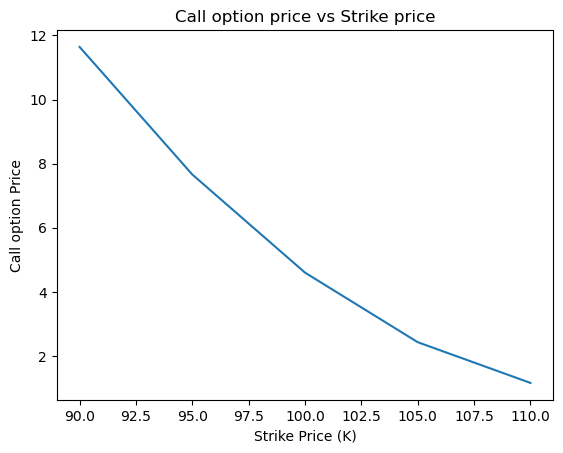

In [26]:
plt.plot(call_prices.keys(), call_prices.values())
plt.title("Call option price vs Strike price")
plt.xlabel("Strike Price (K)")
plt.ylabel("Call option Price");

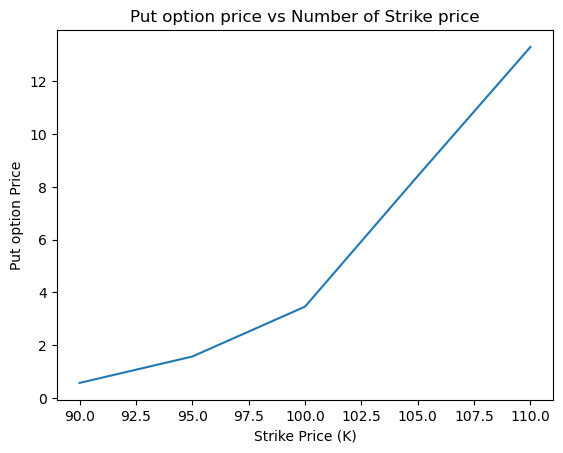

In [27]:
plt.plot(put_prices.keys(), put_prices.values())
plt.title("Put option price vs Number of Strike price")
plt.xlabel("Strike Price (K)")
plt.ylabel("Put option Price");

The price of both the call and put options increases as the strike price moves from deep OTM to deep ITM.

<div style="page-break-after: always;"></div>

# <center>Step 3</center>

### 7. Pricing European options using Black-Scholes, computing delta and delta-hedging combined portfolio

##### a) Price an European Call option with 110% moneyness and an European Put with 95% moneyness using Black-Scholes. Both have 3 months maturity.

In [28]:
S_0 = 100
K = 1.1 * S_0
sigma = 0.2
r = 0.05
T = 3/12 

call_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")
call_price = call_option.compute_black_scholes()

print(f"Price of European call option at 110% moneyness: {call_price}")

Price of European call option at 110% moneyness: 1.19


In [29]:
S_0 = 100
K = 0.95 * S_0
sigma = 0.2
r = 0.05
T = 3/12 

put_option = OptionPricing(S_0, K, sigma, r, T, "put", "European")
put_price = put_option.compute_black_scholes()

print(f"Price of European Put option at 95% moneyness: {put_price}")

Price of European Put option at 95% moneyness: 1.53


##### b) You build a portfolio that buys the previous Call and Put options. What is the delta of the portfolio? How would you delta-hedge this portfolio?

In [30]:
delta_call = call_option.compute_delta_bs()
delta_put = put_option.compute_delta_bs()

print(f"delta of call option: {delta_call}")
print(f"delta of put option: {delta_put}")

delta of call option: 0.218
delta of put option: -0.246


On buying both the options, the combined of portfolio would be
0.218 + 0.246 = 0.464.

* To delta-hedge the portfolio, I would buy 0.464 shares of the same underlying asset at 46.40 initially.
* The delta-hedging process is dynamic and the number of shares bought/sold and the cash account would be adjusted according the delta at time (t) until expiry of the option.



##### c) You build a second portfolio that buys the previous Call option and sells the Put. What is the delta of the portfolio? How would you delta-hedge this portfolio?

In [31]:
delta_call = call_option.compute_delta_bs()
delta_put = put_option.compute_delta_bs()

print(f"delta of call option: {delta_call}")
print(f"delta of put option: {delta_put}")

delta of call option: 0.218
delta of put option: -0.246


If a portfolio is built by buying the call and selling the put option, the combined delta of the portfolio would be 0.218 - 0.246 = -0.028.

* To delta-hedge the portfolio, I would short 0.028 shares of the underlying and lend the money to generate risk-free returns.

* The number of holding shares and the cash account would be dynamically adjusted according to the delta computed at time (t) until the time to expiry.

### 8. Pricing an Up-and-Out barrier option using Monte-Carlo simulation

$ 
\hspace{1cm}S_0 = 120 \\
\hspace{1cm}r = 6\% \\
\hspace{1cm}\sigma = 30\% \\
\hspace{1cm}T = 8 months
$

In [32]:
np.random.seed(42)

S_0 = 120
K = 120
sigma = 0.3
r = 0.06
T = 8/12

uao_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")

uao_price = uao_option.compute_monte_carlo(75_000, uao=141)

print(f"Price of an Up-and-Out barrier option: {uao_price}")

Price of an Up-and-Out barrier option: 0.7


<div style="page-break-after: always;"></div>

### 9. Pricing an Up-and-In barrier option using Monte-Carlo simulation

##### a) Compute the price of the UAI option.

In [33]:
np.random.seed(42)

uai_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")

uai_price = uao_option.compute_monte_carlo(75_000, uai=141)

print(f"Price of an Up-and-In barrier option: {uai_price}")

Price of an Up-and-In barrier option: 13.17


##### b) Compute the price of the vanilla option (same characteristics, no barrier)

In [34]:
np.random.seed(42)

vanilla_option = OptionPricing(S_0, K, sigma, r, T, "call", "European")

vanilla_price = vanilla_option.compute_monte_carlo(75_000)

print(f"Price of vanilla option: {vanilla_price}")

Price of vanilla option: 13.86


##### c) What is the relationship between the prices of the UAO, UAI, and vanilla option? Explain.

|$S_0$ | $K$ | barrier | volatility | time to expiry | Vanilla | UAO | UAI |
|:---:| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 120 | 120 | 141 | 30\% | 8 months | 13.86 | 0.7 | 13.17 | 

* In an *up-and-out-option*, the option becomes worthless, when the price of underlying exceeds the barrier at any point in time before expiry.

* In an *up-and-in option*, the option is worthy only if the price of underlying exceed the barrier at any point in time before expiry.

* Both the UAO and UAI options have a barrier at 141 that limits their potential profitability.

* The vanilla call option has a price of 13.86, the UAO option is priced at 0.7, and the UAI option is priced at 13.17.

* The prices of the UAO and UAI options are related to the price of the vanilla call option, with the upper limit of their prices being the price of the vanilla call option.

* The 30% volatility of the underlying asset increases the likelihood that the underlying asset price will reach the barrier before expiry and hence there are higher chances for UAO to become worthless, while the opposite holds true for the UAI option.

* As the barrier approaches the current underlying asset price at t=0, the price of the UAI option gets closer to the price of the vanilla call option, while the price of the UAO option gets closer to zero.

* As the barrier approaches infinity, the price of the UAI option gets closer to zero, while the price of the UAO option approaches the price of the vanilla call option.